# Chapter 8

In [127]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
import copy

## Example 8.1 - maze

In [115]:
class Maze:
    """
    env will be an interface with the following methods:
    start: return a starting state
    act: takes in an action and return next_state, reward, is_end
    it should also have a class variable for actions allowed
    """
    actions = ['u', 'd', 'l', 'r']
    blocked = [(2,2), (2,3), (2,4), (5,1), (7,3), (7,4), (7,5)]
    start_state = (0, 3)
    goal_state = (8, 5)
    x_lim = 8
    y_lim = 5
    
    def plot(self):
        plt.figure(figsize=(9, 6))
        plt.ylim([0,6])
        plt.xlim([0, 9])
        plt.text(self.start_state[0] + 0.5, self.start_state[1] + 0.5, "S")
        plt.text(self.goal_state[0] + 0.5, self.goal_state[1] + 0.5, "G")
        for coor in self.blocked:
            plt.text(coor[0] + 0.5, coor[1] + 0.5, "X", color='red', fontsize='24')
        plt.grid()
        
    def start(self):
        self.state = self.start_state
        return self.state
    
    def act(self, action):
        if action == 'l':
            next_state = max(0, self.state[0] -1), self.state[1]
        elif action == 'r':
            next_state = min(self.x_lim, self.state[0] + 1), self.state[1]
        elif action == 'd':
            next_state = self.state[0], max(0, self.state[1] - 1)
        else:
            next_state = self.state[0], min(self.state[1] + 1, self.y_lim)
        if next_state in self.blocked:
            next_state = self.state
        self.state = next_state
        if self.state == self.goal_state:
            return self.state, 1, True
        else:
            return self.state, 0, False
        

In [116]:
maze = Maze()

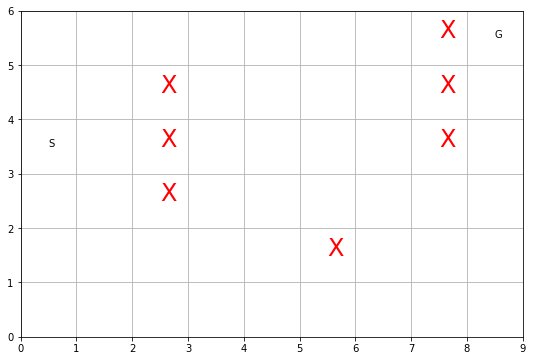

In [117]:
maze.plot()

In [553]:
class DynaQ:
    def __init__(self, env, alpha, epsilon, n, gamma=1):
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.Q = defaultdict(int)
        self.model = {}
        self.actions = env.actions
        self.n = n
        self.stats = [] # each entry will be a tuple of (episode, steps per episode)
        self.archive = []
        self.rewards = []
        
    def select_action(self, state):
        if np.random.uniform() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            best_value = -10000
            best_action = []
            for action in self.actions:
                value = self.Q[state, action]
                if value > best_value:
                    best_value = value
                    best_action = [action]
                elif value == best_value:
                    best_action.append(action)
            return np.random.choice(best_action)
        
    def best_Q(self, state):
        return max([self.Q[state, action] for action in self.actions])
    
    def train(self, episodes, max_timestep = None):
        for episode in range(1, 1 + episodes):
            steps = 0
            state = self.env.start()
            is_end = False
            while not is_end:
                action = self.select_action(state)
                next_state, reward, is_end = self.env.act(action)
                self.Q[state, action] += self.alpha * (reward + self.gamma * self.best_Q(next_state) - self.Q[state, action])
                self.model[state, action] = (reward, next_state)
                state = next_state
                self.rewards.append(reward)
                for i in range(self.n):
                    sample_state, sample_action = list(self.model.keys())[np.random.randint(0, len(self.model))]
                    sample_reward, sample_next_state = self.model[sample_state, sample_action]
                    self.Q[sample_state, sample_action] += self.alpha * (sample_reward + \
                                        self.gamma * self.best_Q(sample_next_state) - self.Q[sample_state, sample_action])
                steps += 1
                if max_timestep is not None and len(self.rewards) > max_timestep:
                    return
                if episode == 2:
                    # archive
                    self.archive.append((state, copy.deepcopy(self.Q)))
            self.stats.append((episode, steps))
        

Text(0.5,1,'Figure 8.3')

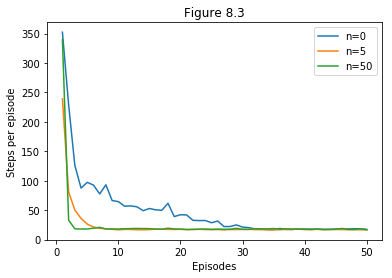

In [126]:
for n in [0, 5, 50]:
    all_steps = []
    for i in range(30):
        np.random.seed = 2*i # generate seed that will be consistent across algs for each repitition
        dyna = DynaQ(maze, 0.1, 0.1, n, 0.95)
        dyna.train(50)
        episodes, steps = zip(*dyna.stats)
        all_steps.append(steps)
    plt.plot(episodes, np.mean(all_steps, axis=0), label='n=%d' %n)

plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Steps per episode')
plt.title('Figure 8.3')

In [145]:
dyna50 = DynaQ(maze, 0.1, 0.1, 50, 0.95)

In [146]:
dyna50.train(2)

In [147]:
state, Q = dyna50.archive[len(dyna50.archive)//2]

Text(0.5,1,'With planning (n=50)')

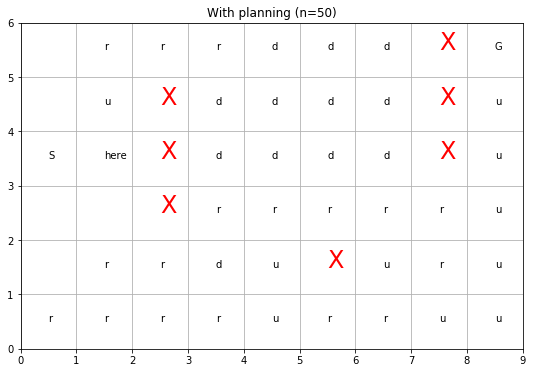

In [148]:
maze.plot()
for x in range(9):
    for y in range(6):
        q = [Q[(x,y), action] for action in maze.actions]
        all_equal = True
        previous = q[0]
        for value in q:
            if not value == previous:
                all_equal = False
        if not all_equal:
            plt.text(x+0.5, y+0.5, maze.actions[np.argmax(q)])
plt.text(state[0] + 0.5, state[1] + 0.5, "here")
plt.title('With planning (n=50)')

In [153]:
dyna0 = DynaQ(maze, 0.1, 0.1, 0, 0.95)

In [154]:
dyna0.train(2)

Text(0.5,1,'Without planning (n=0)')

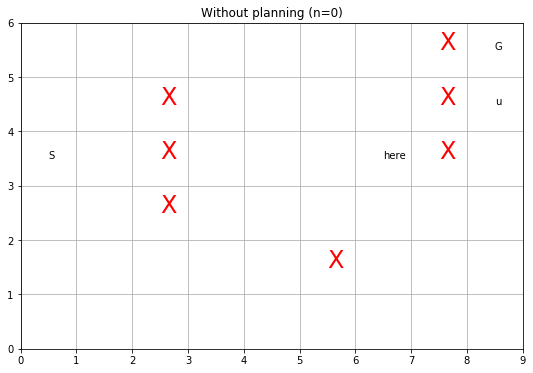

In [155]:
state, Q = dyna0.archive[len(dyna0.archive)//2]
maze.plot()
for x in range(9):
    for y in range(6):
        q = [Q[(x,y), action] for action in maze.actions]
        all_equal = True
        previous = q[0]
        for value in q:
            if not value == previous:
                all_equal = False
        if not all_equal:
            plt.text(x+0.5, y+0.5, maze.actions[np.argmax(q)])
plt.text(state[0] + 0.5, state[1] + 0.5, "here")
plt.title('Without planning (n=0)')

## Example 8.2

In [296]:
class BlockedMaze:
    """
    env will be an interface with the following methods:
    start: return a starting state
    act: takes in an action and return next_state, reward, is_end
    it should also have a class variable for actions allowed
    """
    actions = ['u', 'd', 'l', 'r']
    blocked = [(i,2) for i in range(8)]
    start_state = (3, 0)
    goal_state = (8, 5)
    x_lim = 8
    y_lim = 5
    step = 0
    
    def plot(self):
        plt.figure(figsize=(9, 6))
        plt.ylim([0,6])
        plt.xlim([0, 9])
        plt.text(self.start_state[0] + 0.5, self.start_state[1] + 0.5, "S")
        plt.text(self.goal_state[0] + 0.5, self.goal_state[1] + 0.5, "G")
        for coor in self.blocked:
            plt.text(coor[0] + 0.5, coor[1] + 0.5, "X", color='red', fontsize='24')
        plt.grid()
        
    def start(self):
        self.state = self.start_state
        return self.state
    
    def act(self, action):
        if self.step == 1000:
            self.blocked = self.blocked[1:]
            self.blocked.append((8, 2))
        self.step += 1
        if action == 'l':
            next_state = max(0, self.state[0] -1), self.state[1]
        elif action == 'r':
            next_state = min(self.x_lim, self.state[0] + 1), self.state[1]
        elif action == 'd':
            next_state = self.state[0], max(0, self.state[1] - 1)
        else:
            next_state = self.state[0], min(self.state[1] + 1, self.y_lim)
        if next_state in self.blocked:
            next_state = self.state
        self.state = next_state
        if self.state == self.goal_state:
            return self.state, 1, True
        else:
            return self.state, 0, False
    def reset(self):
        self.step = 0
        self.blocked = [(i,2) for i in range(8)]

In [297]:
blockedMaze = BlockedMaze()

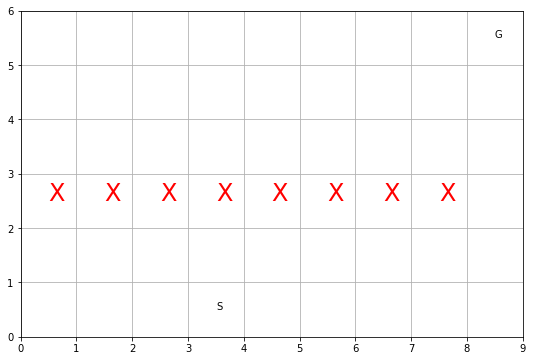

In [298]:
blockedMaze.plot()

In [542]:
class DynaQPlus:
    def __init__(self, env, alpha, epsilon, n, kappa, gamma=1):
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.Q = defaultdict(int)
        self.model = {}
        self.actions = env.actions
        self.n = n
        self.kappa = kappa
        self.rewards = []
        self.steps = 0
        self.visited = {}
        self.visited_states = []
        
    def select_action(self, state):
        if np.random.uniform() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            best_value = -10000
            best_action = []
            for action in self.actions:
                value = self.Q[state, action]
                if value > best_value:
                    best_value = value
                    best_action = [action]
                elif value == best_value:
                    best_action.append(action)
            return np.random.choice(best_action)
        
    def best_Q(self, state):
        return max([self.Q[state, action] for action in self.actions])
    
    def train(self, episodes, max_timestep = None):
        for episode in range(1, 1 + episodes):
            state = self.env.start()
            is_end = False
            while not is_end:
                action = self.select_action(state)
                next_state, reward, is_end = self.env.act(action)
                self.Q[state, action] += self.alpha * (reward + self.gamma * self.best_Q(next_state) - self.Q[state, action])
                self.model[state, action] = (reward, next_state, self.steps)
                for a in self.actions:
                    if not a == action and (state, a) not in self.model.keys():
                        self.model[(state, a)] = (0, state, 0)
                state = next_state
                self.rewards.append(reward)
                for i in range(self.n):
                    sample_state, sample_action = list(self.model.keys())[np.random.randint(0, len(self.model))]
                    sample_reward, sample_next_state, time = self.model[sample_state, sample_action]
                    sample_reward += self.kappa * np.sqrt(self.steps - time)
                    self.Q[sample_state, sample_action] += self.alpha * (sample_reward + \
                                        self.gamma * self.best_Q(sample_next_state) - self.Q[sample_state, sample_action])
                self.steps += 1
                if max_timestep is not None and self.steps > max_timestep:
                    return 
        

In [564]:
dynaQ_rewards = []
dynaQplus_rewards = []
for i in range(30):
    blockedMaze.reset()
    dynaQ = DynaQ(blockedMaze, 0.8, 0.1, 10, 0.95)
    dynaQ.train(200, max_timestep=3000)
    dynaQ_rewards.append(np.cumsum(dynaQ.rewards[:3000]))
    
for i in range(30):
    blockedMaze.reset()
    dynaQplus = DynaQPlus(blockedMaze, 0.8, 0.1, 10, 1e-4, 0.95)
    dynaQplus.train(200, max_timestep=3000)
    dynaQplus_rewards.append(np.cumsum(dynaQplus.rewards[:3000]))

Text(0,0.5,'cummulative reward')

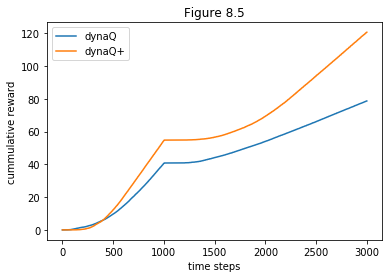

In [565]:
plt.plot(range(3000), np.mean(dynaQ_rewards, axis=0), label='dynaQ')
plt.plot(range(3000), np.mean(dynaQplus_rewards, axis=0), label='dynaQ+')
plt.legend()
plt.title('Figure 8.5')
plt.xlabel('time steps')
plt.ylabel('cummulative reward')

## Example 8.3 shortcut maze

In [543]:
class ShortcutMaze:
    """
    env will be an interface with the following methods:
    start: return a starting state
    act: takes in an action and return next_state, reward, is_end
    it should also have a class variable for actions allowed
    """
    actions = ['u', 'd', 'l', 'r']
    blocked = [(i,2) for i in range(1, 9)]
    start_state = (3, 0)
    goal_state = (8, 5)
    x_lim = 8
    y_lim = 5
    step = 0
    
    def plot(self):
        plt.figure(figsize=(9, 6))
        plt.ylim([0,6])
        plt.xlim([0, 9])
        plt.text(self.start_state[0] + 0.5, self.start_state[1] + 0.5, "S")
        plt.text(self.goal_state[0] + 0.5, self.goal_state[1] + 0.5, "G")
        for coor in self.blocked:
            plt.text(coor[0] + 0.5, coor[1] + 0.5, "X", color='red', fontsize='24')
        plt.grid()
        
    def start(self):
        self.state = self.start_state
        return self.state
    
    def act(self, action):
        if self.step == 3000:
            self.blocked = self.blocked[:-1]
        self.step += 1
        if action == 'l':
            next_state = max(0, self.state[0] -1), self.state[1]
        elif action == 'r':
            next_state = min(self.x_lim, self.state[0] + 1), self.state[1]
        elif action == 'd':
            next_state = self.state[0], max(0, self.state[1] - 1)
        else:
            next_state = self.state[0], min(self.state[1] + 1, self.y_lim)
        if next_state in self.blocked:
            next_state = self.state
        self.state = next_state
        if self.state == self.goal_state:
            return self.state, 1, True
        else:
            return self.state, 0, False
    def reset(self):
        self.step = 0
        self.blocked = [(i,2) for i in range(1, 9)]

In [560]:
shortcut_maze = ShortcutMaze()

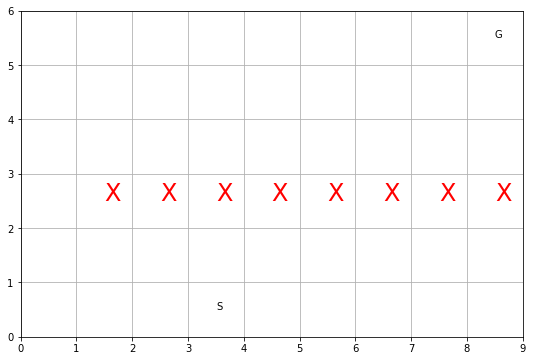

In [561]:
shortcut_maze.plot()

In [562]:
dynaQ_rewards = []
dynaQplus_rewards = []
for i in range(5):
    shortcut_maze.reset()
    dynaQ = DynaQ(shortcut_maze, 0.7, 0.1, 50, 0.95)
    dynaQ.train(800, max_timestep=6000)
    dynaQ_rewards.append(np.cumsum(dynaQ.rewards[:6000]))
    
for i in range(5):
    shortcut_maze.reset()
    dynaQplus = DynaQPlus(shortcut_maze, 0.7, 0.1, 50, 1e-3, 0.95)
    dynaQplus.train(800, max_timestep=6000)
    dynaQplus_rewards.append(np.cumsum(dynaQplus.rewards[:6000]))

Text(0,0.5,'cummulative reward')

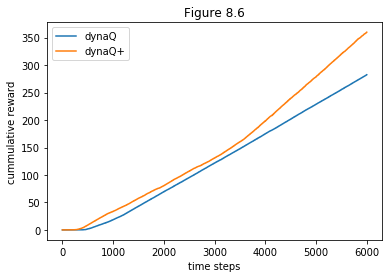

In [563]:
plt.plot(range(6000), np.mean(dynaQ_rewards, axis=0), label='dynaQ')
plt.plot(range(6000), np.mean(dynaQplus_rewards, axis=0), label='dynaQ+')
plt.legend()
plt.title('Figure 8.6')
plt.xlabel('time steps')
plt.ylabel('cummulative reward')